In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from helpers import *
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa

/Users/danielebelfiore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Getting the score and dividing in left / right hand

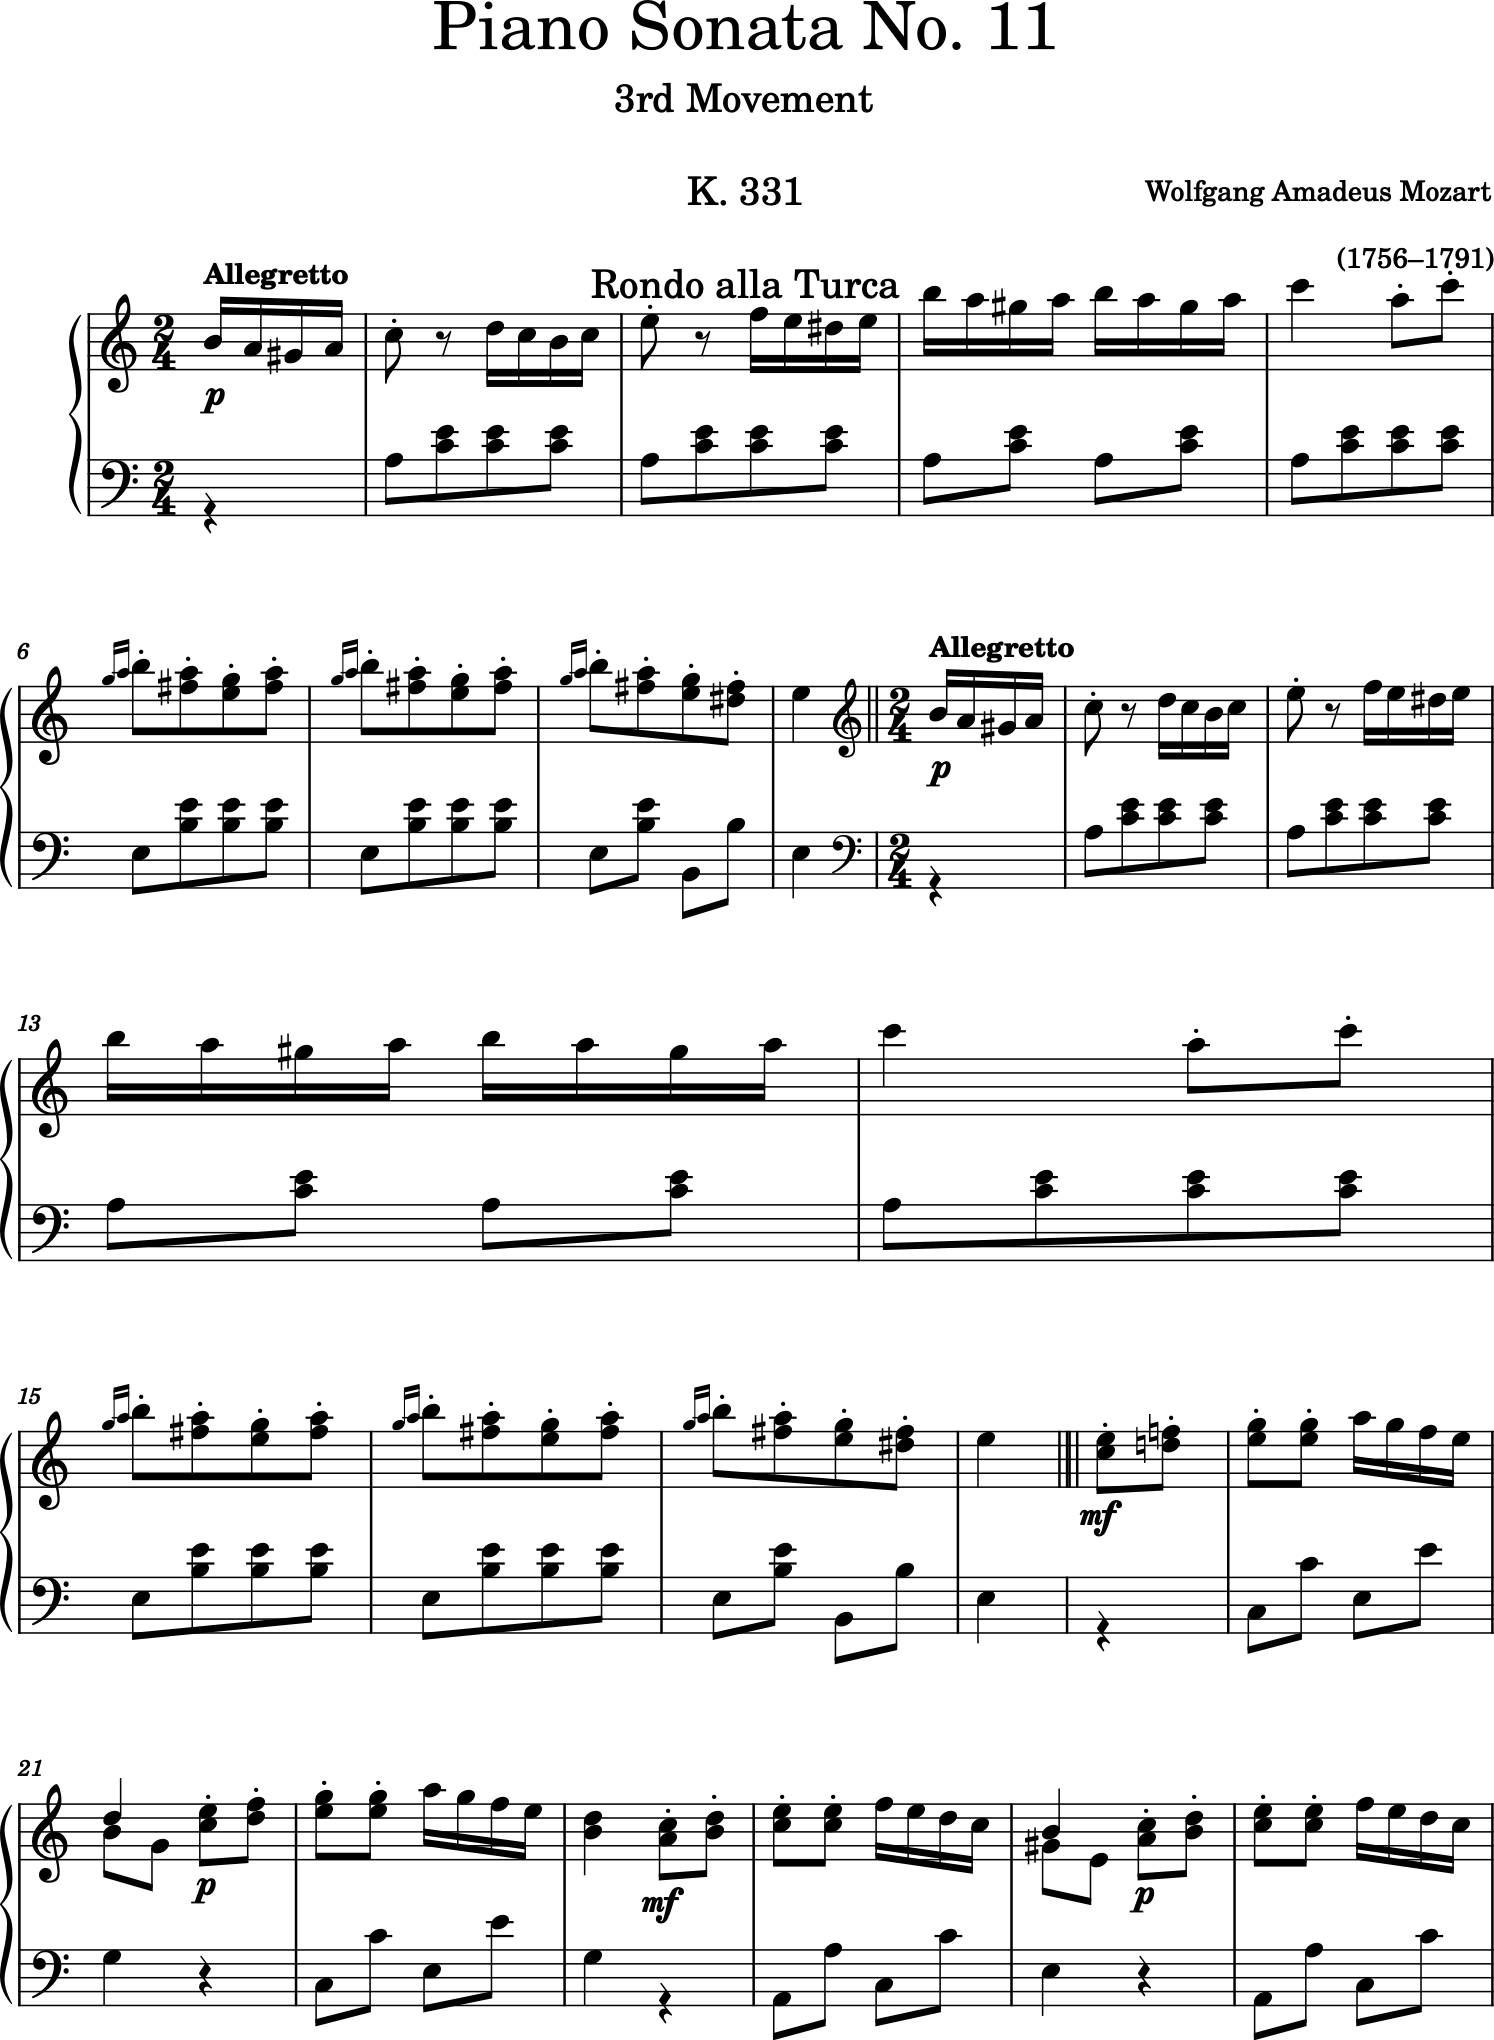

In [2]:
# Import, linearize, and display the sample piece
sample_score = converter.parse('xml/xml_score.musicxml') # converter is from the music21 package
linearized_sample_score = sample_score.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_sample_score.show()

In [3]:
from music21 import converter

# Load the MusicXML fil
# Print parts and their IDs or names to identify right and left hands
for part in sample_score.parts:
    print(part.id, part.partName)


P1-Staff1 Piano
P1-Staff2 Piano


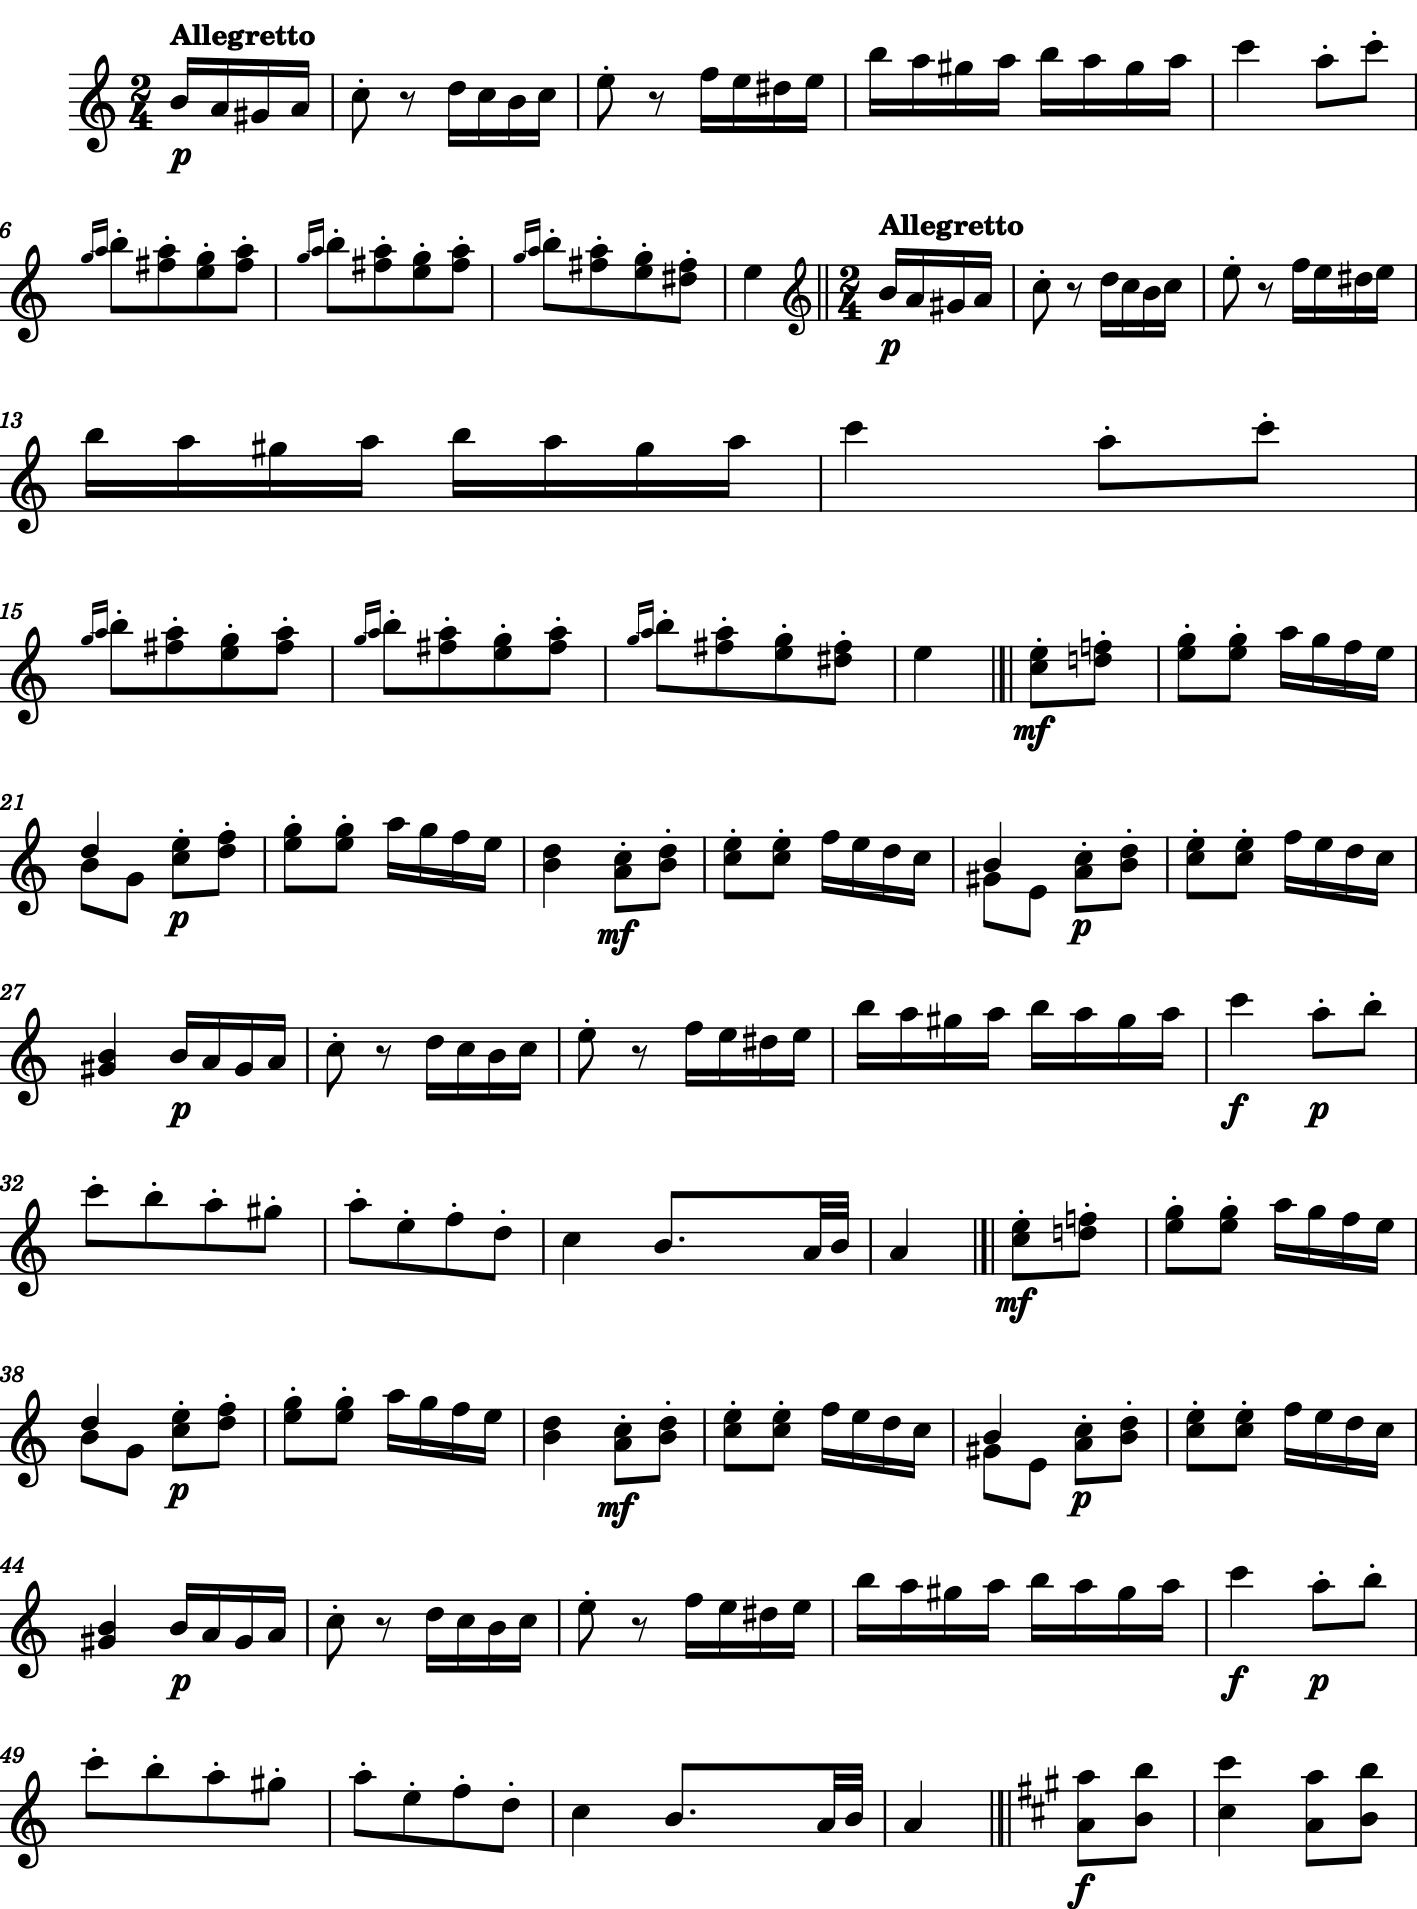

In [4]:
right_hand = sample_score.parts[0]  # Assuming the right hand is the first part
right_hand_notes = [note for note in right_hand.recurse().notes]


linearized_right_score = right_hand.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_right_score.show()

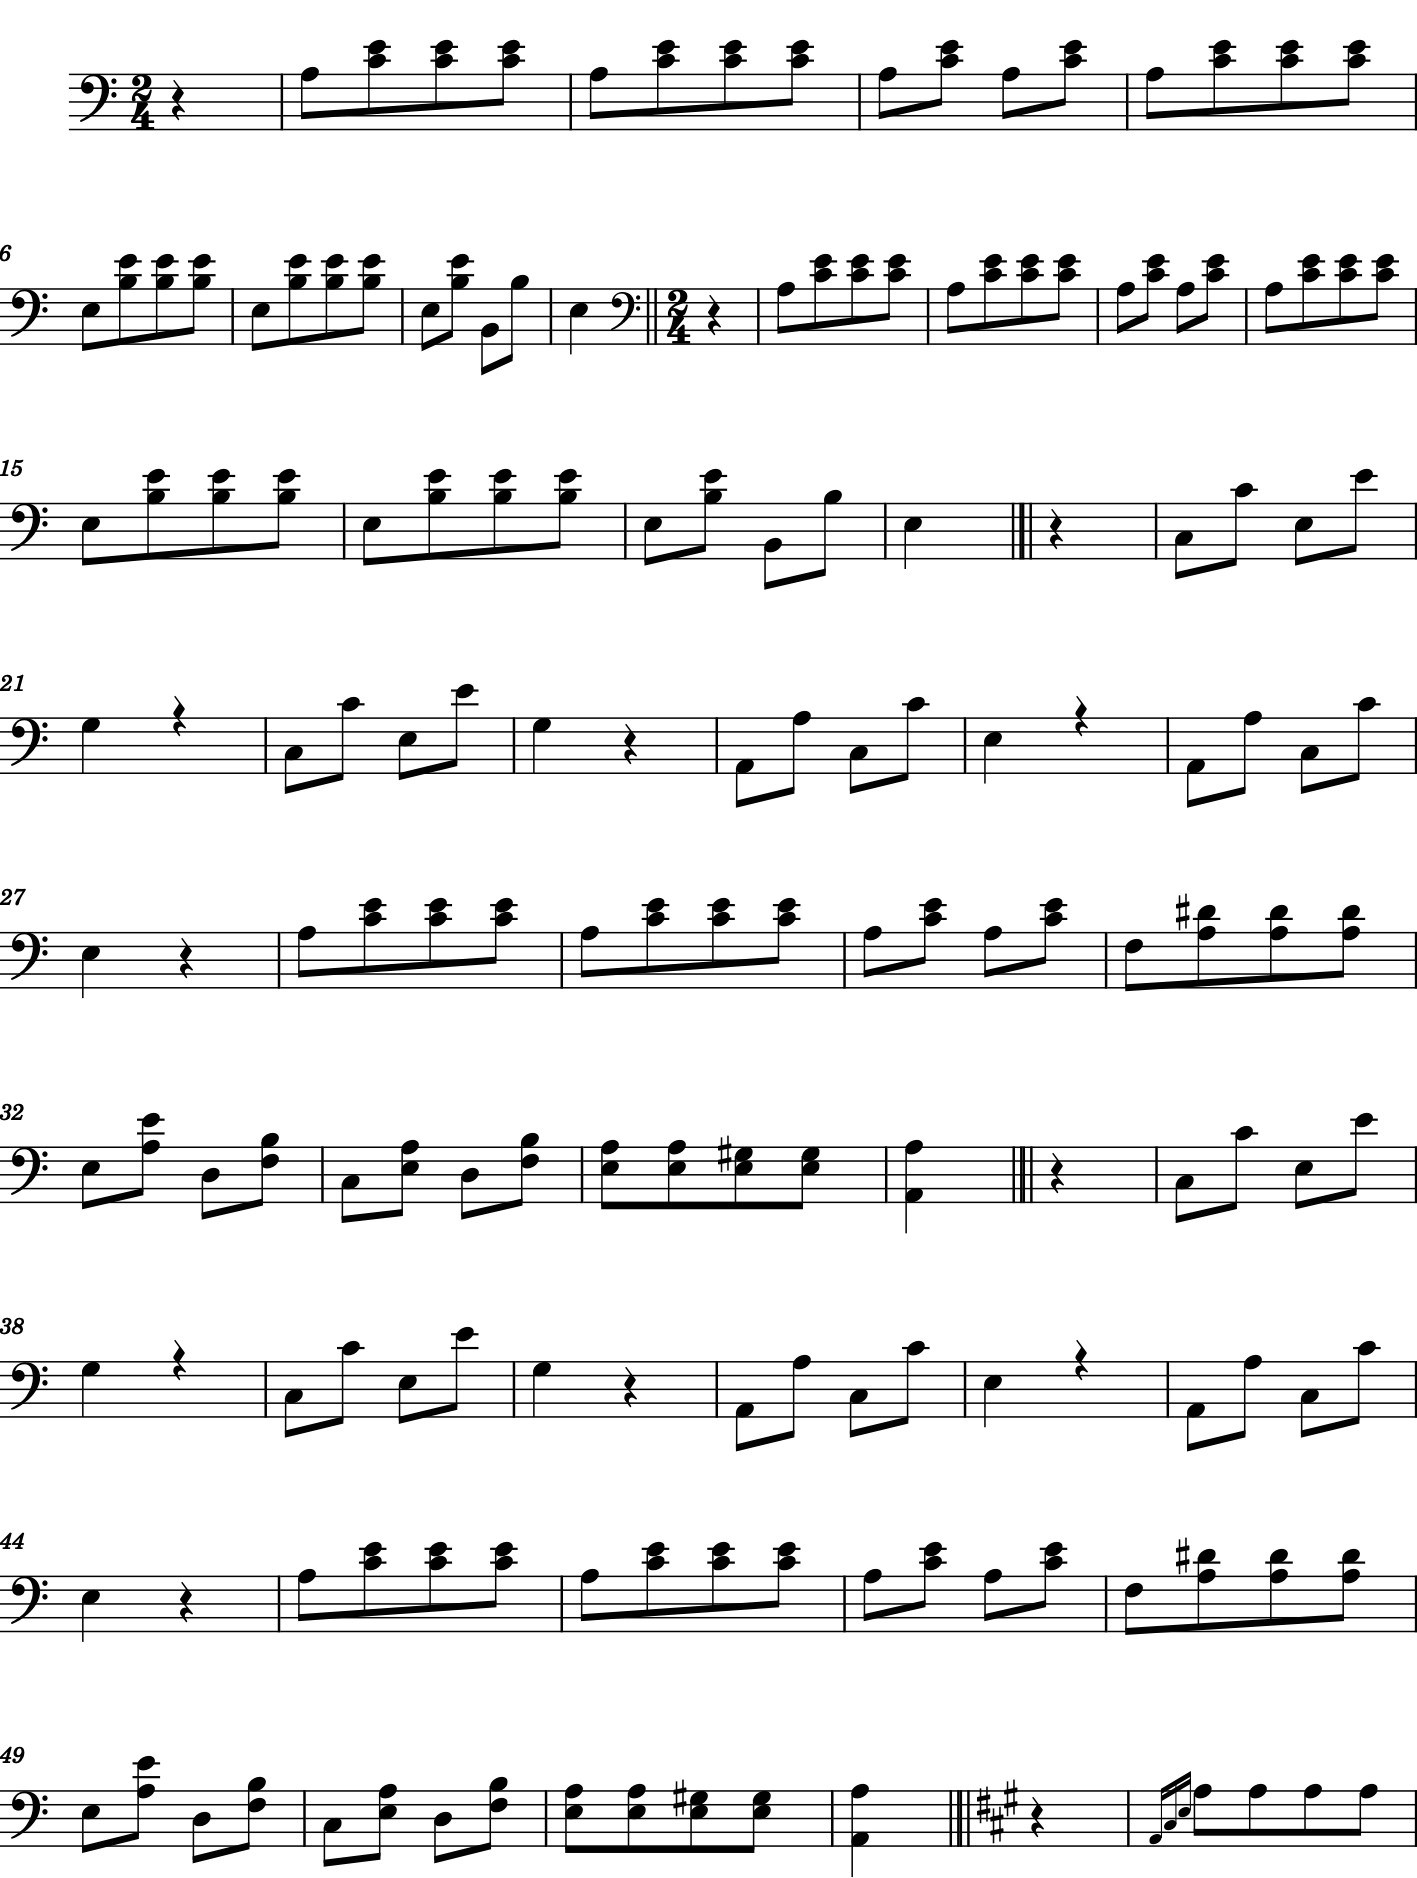

In [5]:
left_hand = sample_score.parts[1]  # Assuming the right hand is the first part
left_hand_notes = [note for note in right_hand.recurse().notes]

#not really using repetitions in the end
linearized_left_score = left_hand.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_left_score.show()

# SSM for individual notes

In [6]:

# Load the MusicXML file

left_hand_midi_sequence = []

for event in left_hand.recurse().notes:
    if event.isNote:
        left_hand_midi_sequence.append(event.pitch.midi)
    elif event.isChord:
        for note in event:
            left_hand_midi_sequence.append(note.pitch.midi)



# Load the MusicXML file

right_hand_midi_sequence = []

for event in right_hand.recurse().notes:
    if event.isNote:
        right_hand_midi_sequence.append(event.pitch.midi)
    elif event.isChord:
        for note in event:
            right_hand_midi_sequence.append(note.pitch.midi)


In [7]:
# Kronecker function for upcoming matrix (do not modify)
def kronecker_delta(x, y):
    if x == y:
        return 1
    else:
        return 0

# Create similarity matrix from MIDI note numbers
def calculate_ssm(sequence):
    length = len(sequence)
    ssm = np.zeros((length, length))

    ## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
    i = 0
    for element_i in sequence:
        j = 0
        for element_j in sequence:
            ssm[i][j] = kronecker_delta(element_i, element_j)
            j += 1
        i += 1
    ## END STUDENT SECTION  ##
    
    return ssm


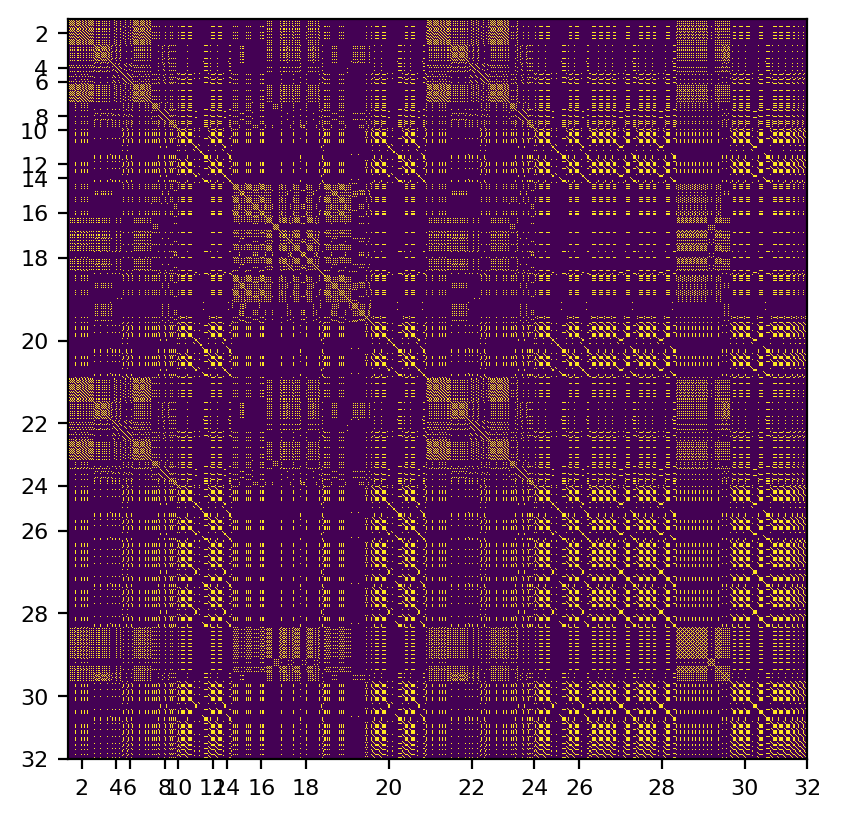

In [8]:

left_self_sim_mat1 = calculate_ssm(left_hand_midi_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(left_self_sim_mat1, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

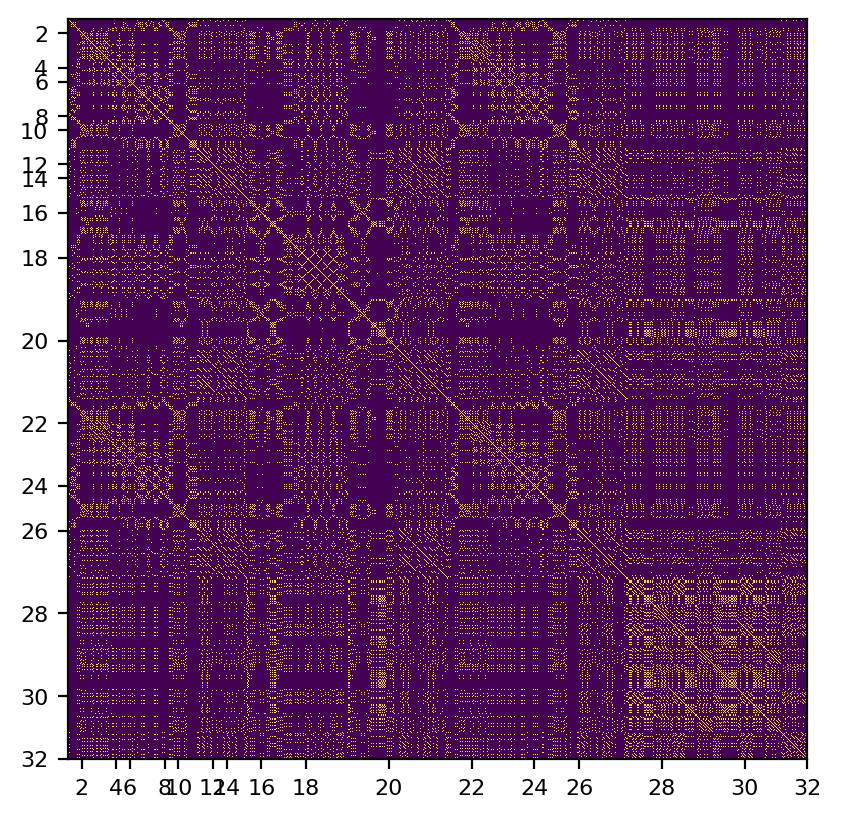

In [9]:


right_self_sim_mat1 = calculate_ssm(right_hand_midi_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(right_self_sim_mat1, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

# SSM for measures

In [10]:
# Cast measures as lists of MIDI note numbers

# Assuming 'left_hand' is a Part object representing the left-hand part of the piano score
left_midi_measure_sequence = []

for measure in left_hand.getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        if event.isNote:
            measure_midi_list.append(event.pitch.midi)
        elif event.isChord:
            for note in event.notes:
                measure_midi_list.append(note.pitch.midi)
    left_midi_measure_sequence.append(measure_midi_list)


# Assuming 'left_hand' is a Part object representing the left-hand part of the piano score
right_midi_measure_sequence = []

for measure in right_hand.getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        if event.isNote:
            measure_midi_list.append(event.pitch.midi)
        elif event.isChord:
            for note in event.notes:
                measure_midi_list.append(note.pitch.midi)
    right_midi_measure_sequence.append(measure_midi_list)



In [11]:
# colouring lines when there's the end of a section (check the score tho)
# commenting the horizontal not to create a mess

def drawlines_measures():
    lines = {  
        9: 'red',
        25: 'green',
        34: 'blue',
        43:'orange',
        60:'pink',
        69:'white',
        79:'red',
        95:'green',
        104: 'purple',
        136: 'white'
    }

    for tick, color in lines.items():
        plt.axvline(x=tick, color=color, linestyle='--', label=f'Vertical line at {tick}', linewidth=1)
        # plt.axhline(y=tick, color=color, linestyle='--', label=f'Horizontal line at {tick}', linewidth=1)

def drawlines_beats():
    lines = {  
        9: 'red',
        25: 'green',
        34: 'blue',
        43:'orange',
        60:'pink',
        69:'white',
        79:'red',
        95:'green',
        104: 'purple',
        136: 'white'
    }

    for tick, color in lines.items():
        plt.axvline(x=tick*2, color=color, linestyle='--', label=f'Vertical line at {tick}', linewidth=1)
        # plt.axhline(y=tick*2, color=color, linestyle='--', label=f'Horizontal line at {tick}', linewidth=1)


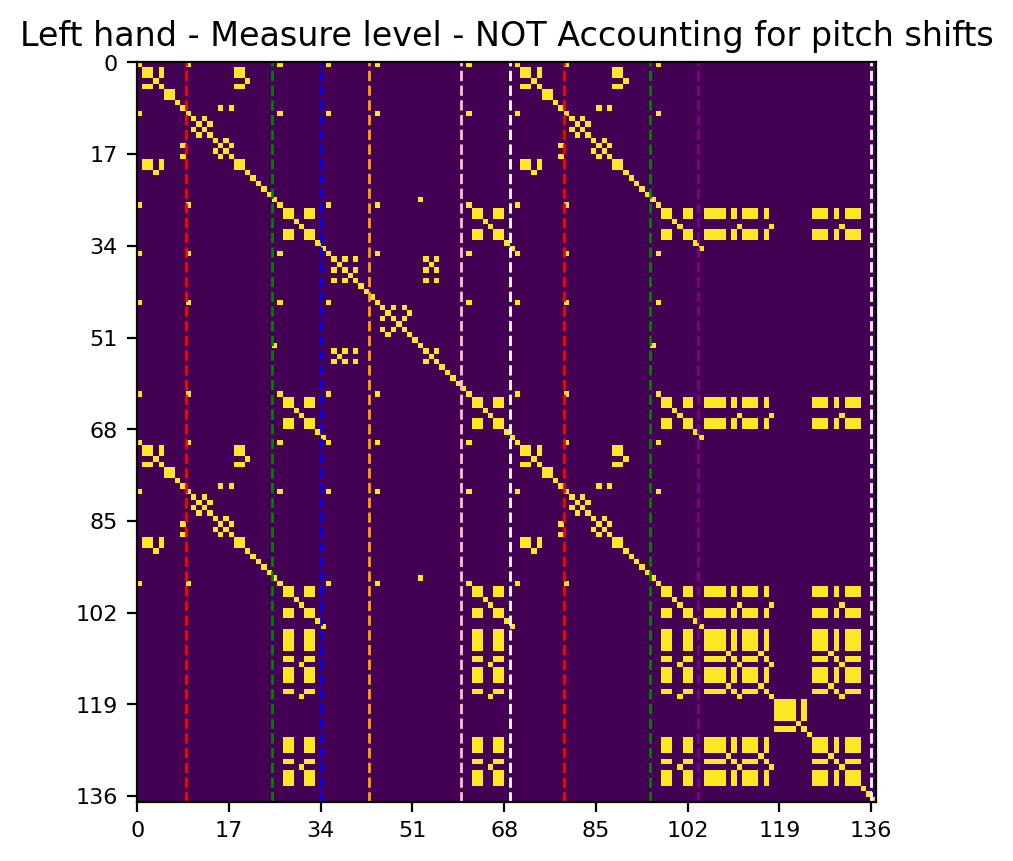

In [12]:

# Create similarity matrix from MIDI measure lists
left_self_sim_mat2 = calculate_ssm(left_midi_measure_sequence)

# Number of measures
num_measures = len(left_midi_measure_sequence)

# Set ticks dynamically based on the number of measures
tick_positions = range(0, num_measures + 1, max(1, num_measures // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_measures()

plt.imshow(left_self_sim_mat2, cmap='viridis', interpolation='nearest', extent=[0, num_measures, num_measures, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Left hand - Measure level - NOT Accounting for pitch shifts")
plt.show()

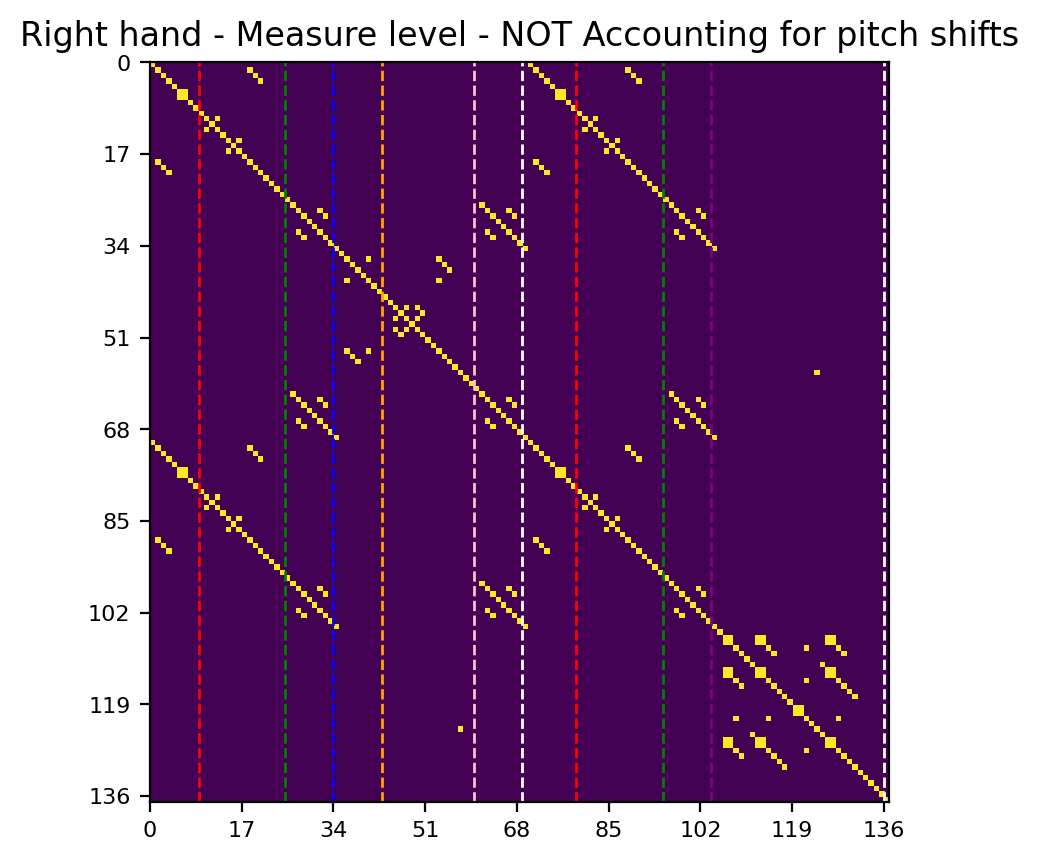

In [13]:

# Create similarity matrix from MIDI measure lists
right_self_sim_mat2 = calculate_ssm(right_midi_measure_sequence)

# Number of measures
num_measures = len(right_midi_measure_sequence)

# Set ticks dynamically based on the number of measures
tick_positions = range(0, num_measures + 1, max(1, num_measures // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

# Add lines
drawlines_measures()

plt.imshow(right_self_sim_mat2, cmap='viridis', interpolation='nearest', extent=[0, num_measures, num_measures, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Right hand - Measure level - NOT Accounting for pitch shifts")
plt.show()

### Considering pitch transposition when computing the similarity

In [14]:
# Kronecker function with transposition check
def kronecker_delta_transinvar(x, y):
    # Check if both sequences are empty, or if one is empty
    if not x and not y:
        return 1  # Consider two empty sequences as similar
    if not x or not y:
        return 0  # If one is empty and the other is not, they are not similar

    if x == y:
        return 1
    if len(x) != len(y):
        return 0

    # Calculate the difference between corresponding elements
    diff_list = [from_y - from_x for from_x, from_y in zip(x, y)]

    # Check if all differences are the same (indicating a transposition)
    if all(diff == diff_list[0] for diff in diff_list):
        return 0.5
    return 0


# Create TI distance matrix from MIDI measure lists, reflecting equality under transposition
def calculate_ti_ssm(sequence):
    length = len(sequence)
    ti_ssm = np.zeros((length, length))

    i = 0
    for element_i in sequence:
        j = 0
        for element_j in sequence:
            ti_ssm[i][j] = kronecker_delta_transinvar(element_i, element_j)
            j += 1
        i += 1

    return ti_ssm


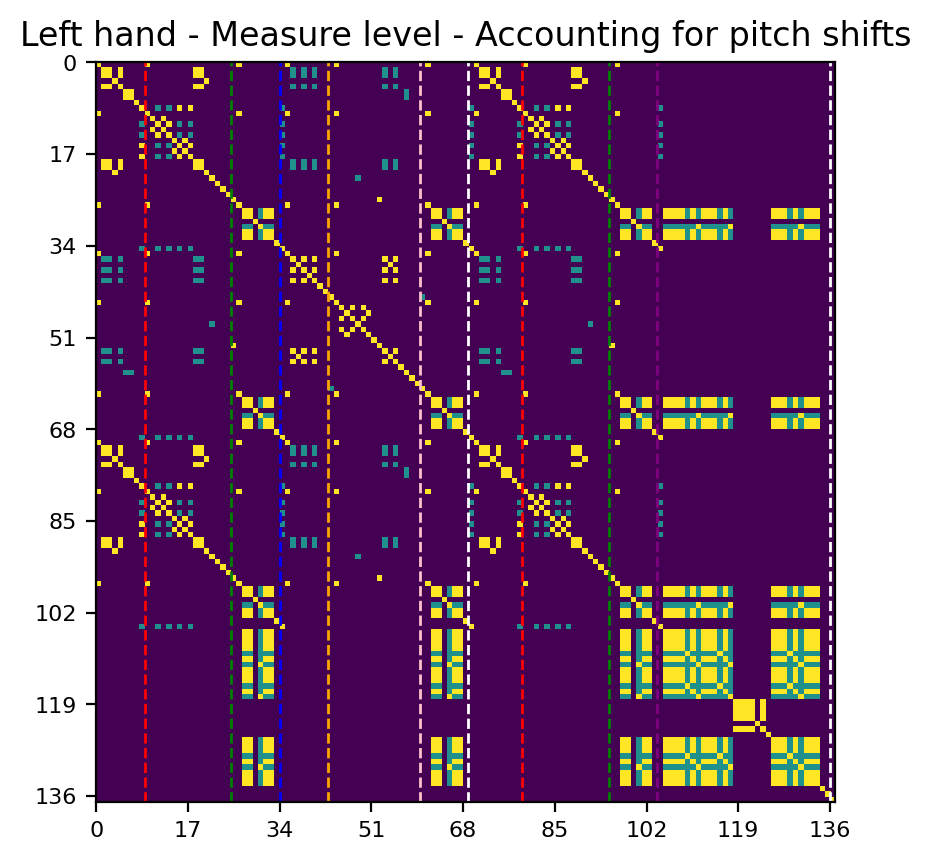

In [15]:

left_self_sim_mat3 = calculate_ti_ssm(left_midi_measure_sequence)

# Number of measures
num_measures = len(left_midi_measure_sequence)

# Set ticks dynamically based on the number of measures
tick_positions = range(0, num_measures + 1, max(1, num_measures // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_measures()

plt.imshow(left_self_sim_mat3, cmap='viridis', interpolation='nearest', extent=[0, num_measures, num_measures, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Left hand - Measure level - Accounting for pitch shifts")
plt.show()

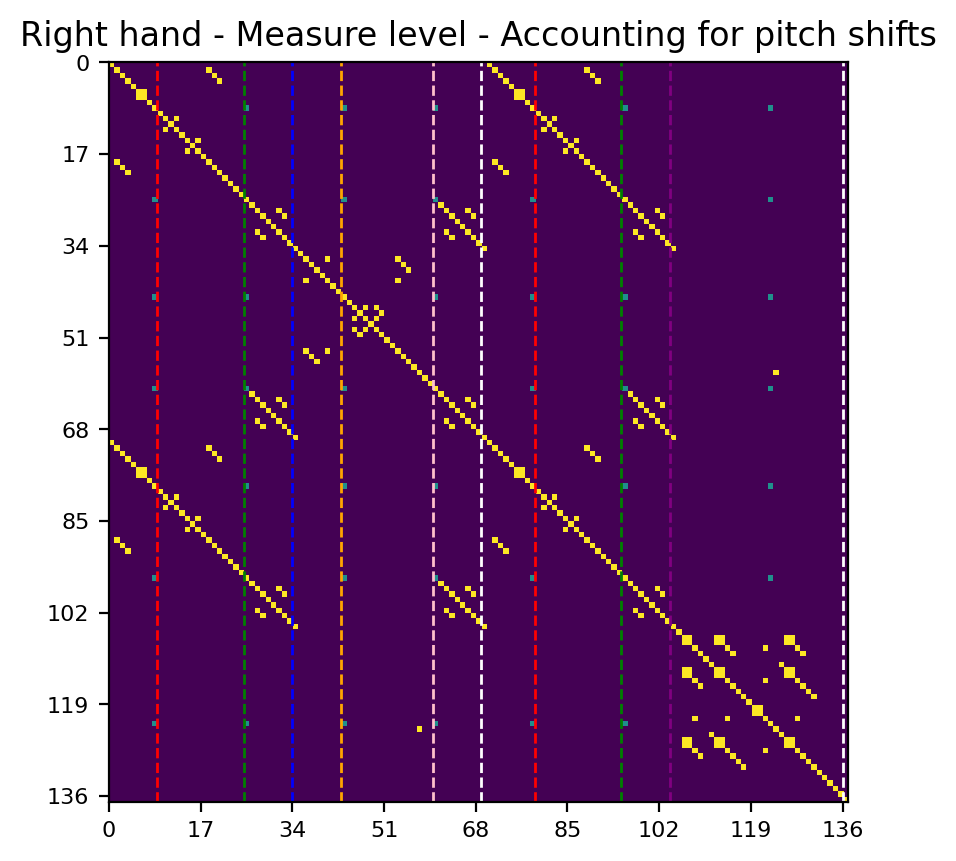

In [16]:
right_self_sim_mat3 = calculate_ti_ssm(right_midi_measure_sequence)

# Number of measures
num_measures = len(right_midi_measure_sequence)

# Set ticks dynamically based on the number of measures
tick_positions = range(0, num_measures + 1, max(1, num_measures // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_measures()

plt.imshow(right_self_sim_mat3, cmap='viridis', interpolation='nearest', extent=[0, num_measures, num_measures, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Right hand - Measure level - Accounting for pitch shifts")
plt.show()

# SSM for the individual beats
I figured that, as the melody start shifted by one beat, similarities between the measures may not be enough, so I started working at a beat level

In [17]:
from music21 import stream

# Assuming 'right_hand' is a Part object representing the right-hand part of the piano score
right_midi_beat_sequence = []

# Iterate through each measure and then each note
for measure in right_hand.getElementsByClass(stream.Measure):
    for event in measure.recurse().notes:
        start_time = event.offset + measure.number * measure.barDuration.quarterLength  # Calculate start time in "quarters"
        beat_number = int(start_time)  # Convert start time to an integer to get the beat number

        # Initialize the list for this beat number if it doesn't exist
        if len(right_midi_beat_sequence) <= beat_number:
            right_midi_beat_sequence.extend([[] for _ in range(beat_number - len(right_midi_beat_sequence) + 1)])

        # Append MIDI note numbers to the corresponding beat
        if event.isNote:
            right_midi_beat_sequence[beat_number].append(event.pitch.midi)
        elif event.isChord:
            for note in event.notes:
                right_midi_beat_sequence[beat_number].append(note.pitch.midi)

# Assuming 'right_hand' is a Part object representing the right-hand part of the piano score
left_midi_beat_sequence = []

# Iterate through each measure and then each note
for measure in left_hand.getElementsByClass(stream.Measure):
    for event in measure.recurse().notes:
        start_time = event.offset + measure.number * measure.barDuration.quarterLength  # Calculate start time in "quarters"
        beat_number = int(start_time)  # Convert start time to an integer to get the beat number

        # Initialize the list for this beat number if it doesn't exist
        if len(left_midi_beat_sequence) <= beat_number:
            left_midi_beat_sequence.extend([[] for _ in range(beat_number - len(left_midi_beat_sequence) + 1)])

        # Append MIDI note numbers to the corresponding beat
        if event.isNote:
            left_midi_beat_sequence[beat_number].append(event.pitch.midi)
        elif event.isChord:
            for note in event.notes:
                left_midi_beat_sequence[beat_number].append(note.pitch.midi)


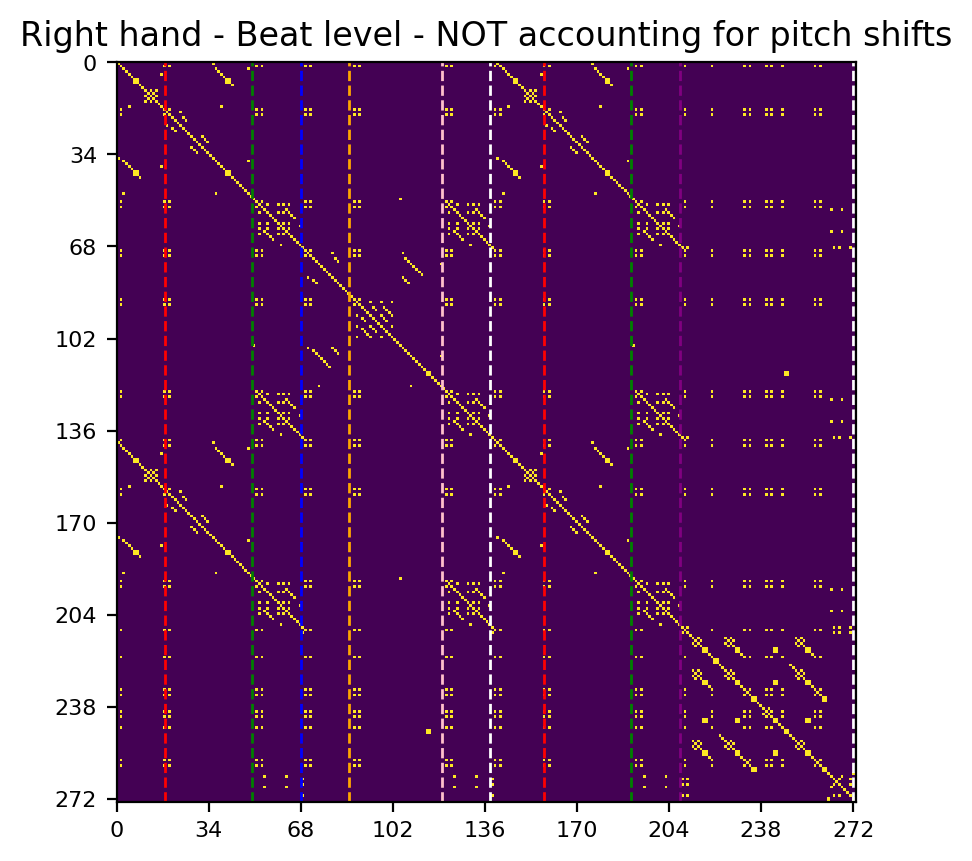

In [18]:

# Create similarity matrix from MIDI beat lists
right_self_sim_mat2 = calculate_ssm(right_midi_beat_sequence)

# Number of beats
num_beats = len(right_midi_beat_sequence)

# Set ticks dynamically based on the number of beats
tick_positions = range(0, num_beats + 1, max(1, num_beats // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_beats()

plt.imshow(right_self_sim_mat2, cmap='viridis', interpolation='nearest', extent=[0, num_beats, num_beats, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Right hand - Beat level - NOT accounting for pitch shifts")
plt.show()


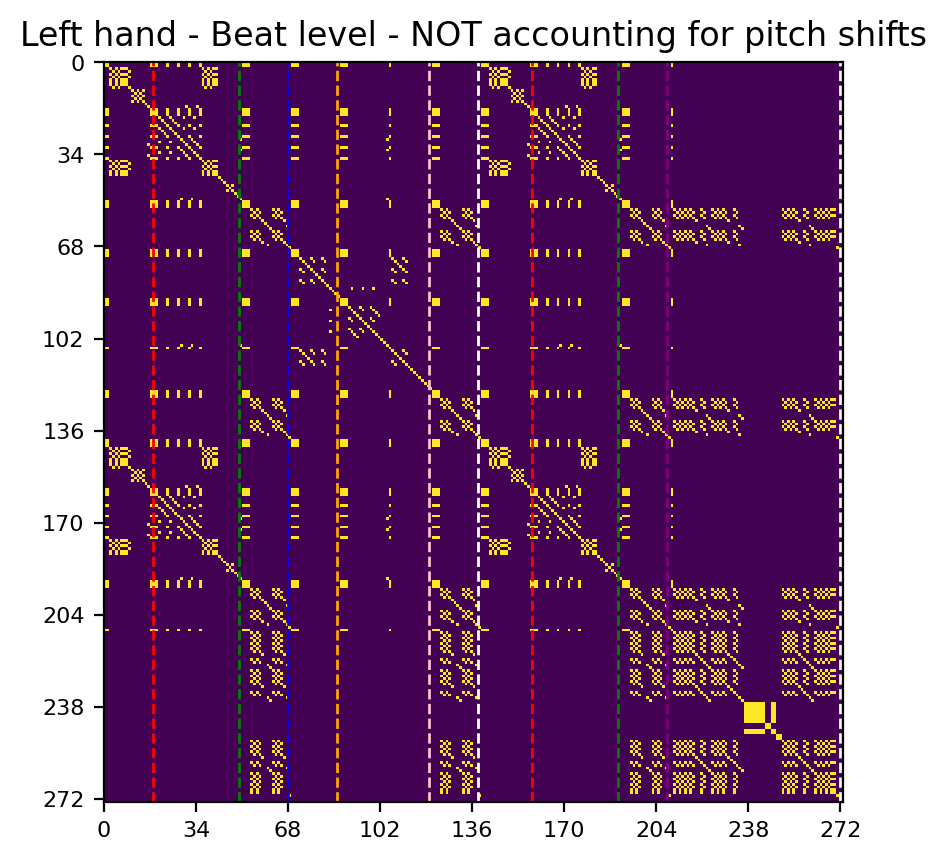

In [19]:

# Create similarity matrix from MIDI beat lists
left_self_sim_mat2 = calculate_ssm(left_midi_beat_sequence)

# Number of beats
num_beats = len(left_midi_beat_sequence)

# Set ticks dynamically based on the number of beats
tick_positions = range(0, num_beats + 1, max(1, num_beats // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_beats()

plt.imshow(left_self_sim_mat2, cmap='viridis', interpolation='nearest', extent=[0, num_beats, num_beats, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Left hand - Beat level - NOT accounting for pitch shifts")
plt.show()


### Accounting for pitch transposition (imperfect similarity in blue)

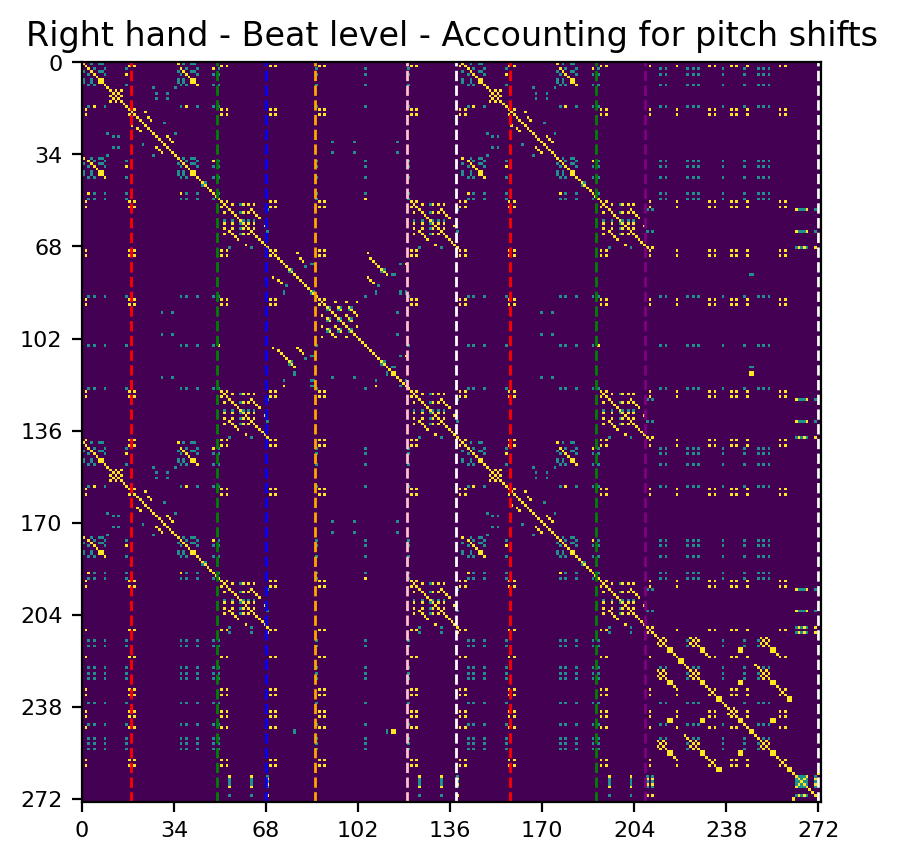

In [20]:

# Create similarity matrix from MIDI beat lists
right_self_sim_mat3 = calculate_ti_ssm(right_midi_beat_sequence)

# Number of beats
num_beats = len(right_midi_beat_sequence)

# Set ticks dynamically based on the number of beats
tick_positions = range(0, num_beats + 1, max(1, num_beats // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_beats()

plt.imshow(right_self_sim_mat3, cmap='viridis', interpolation='nearest', extent=[0, num_beats, num_beats, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Right hand - Beat level - Accounting for pitch shifts")
plt.show()


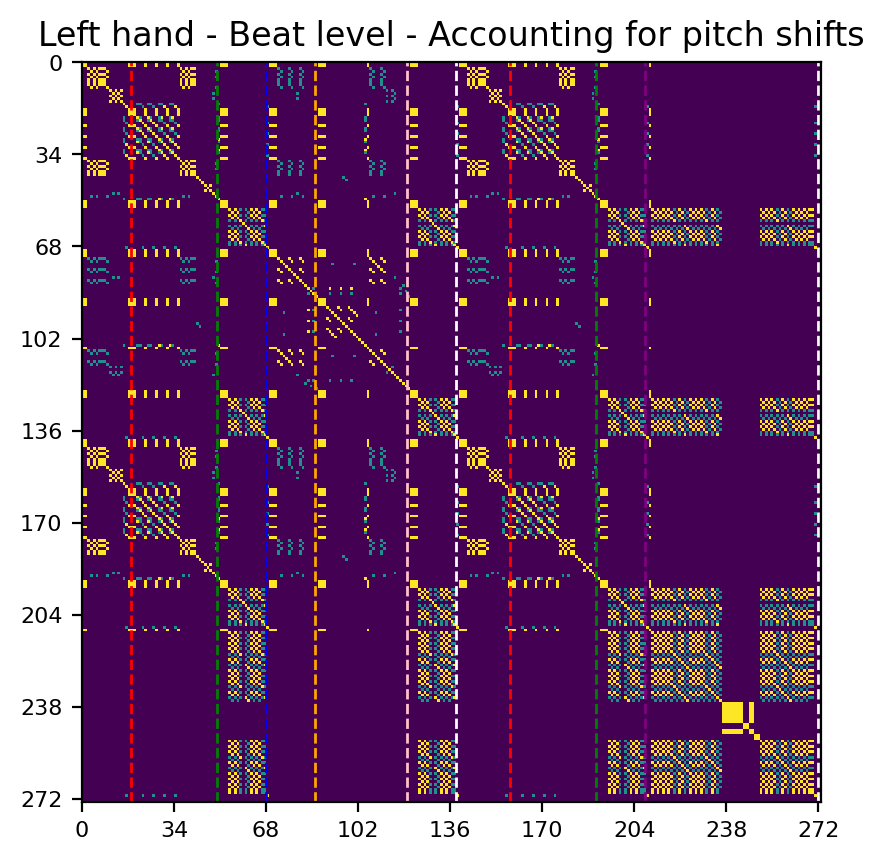

In [21]:

# Create similarity matrix from MIDI beat lists
left_self_sim_mat3 = calculate_ti_ssm(left_midi_beat_sequence)

# Number of beats
num_beats = len(left_midi_beat_sequence)

# Set ticks dynamically based on the number of beats
tick_positions = range(0, num_beats + 1, max(1, num_beats // 8))  # Adjust the step for readability
tick_labels = [str(i) for i in tick_positions]

drawlines_beats()

plt.imshow(left_self_sim_mat3, cmap='viridis', interpolation='nearest', extent=[0, num_beats, num_beats, 0])
plt.xticks(tick_positions, tick_labels, fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)
plt.title("Left hand - Beat level - Accounting for pitch shifts")
plt.show()


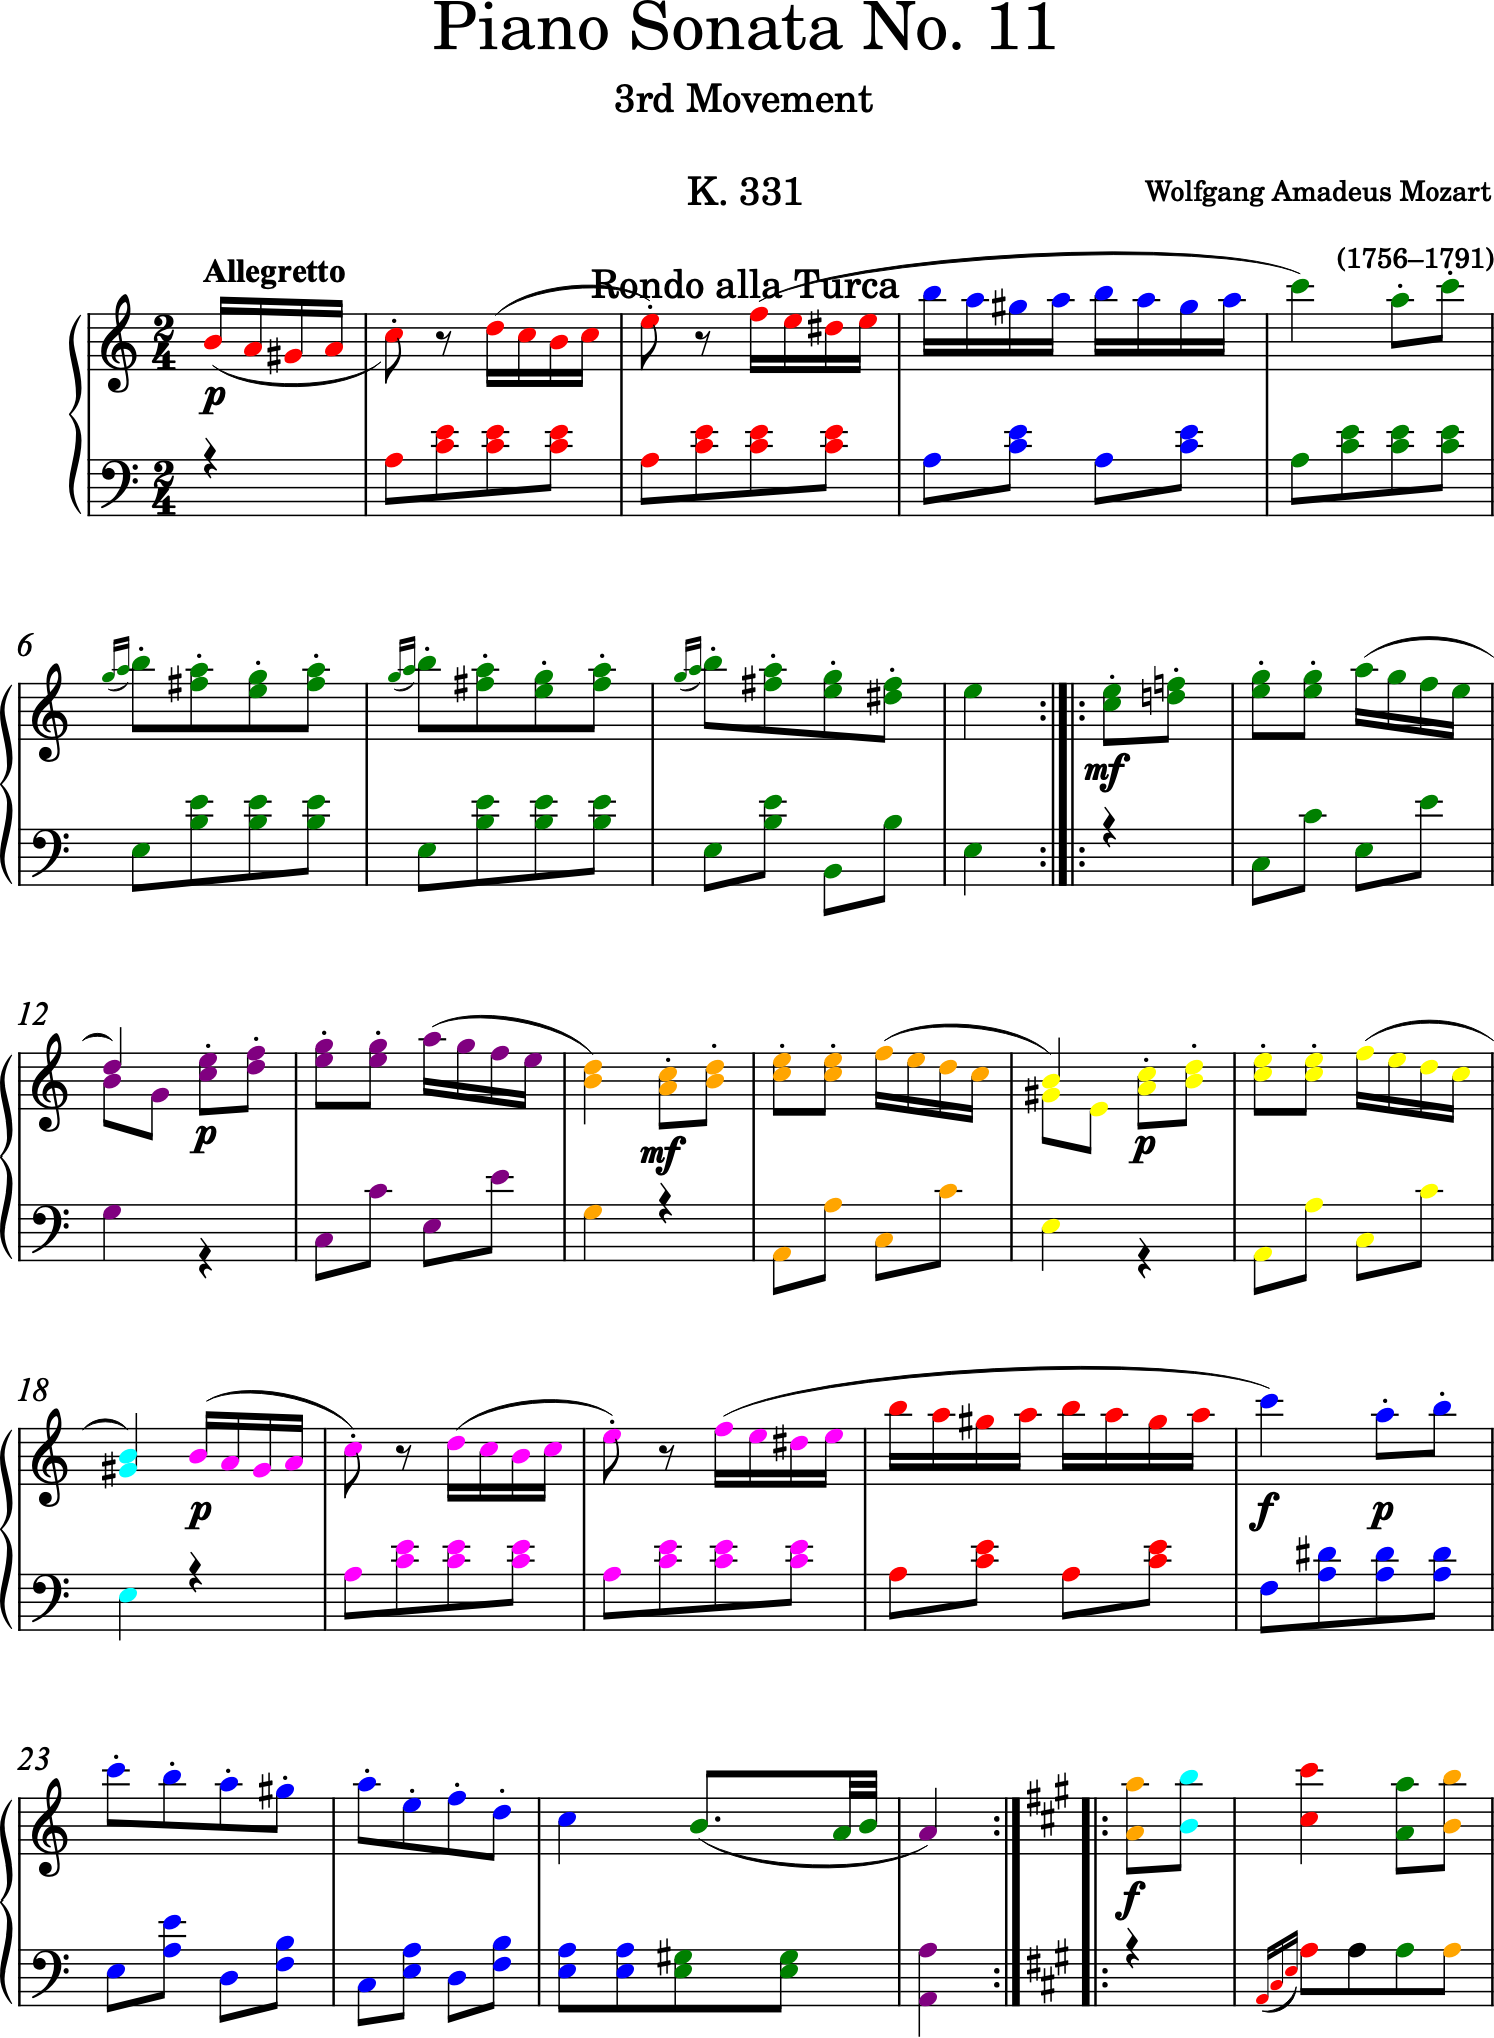

In [37]:
import music21

def extract_score_attributes(part):
    score_data = []
    for element in part.flat.notes:
        if isinstance(element, music21.note.Note):
            attributes = {
                'offset': element.offset,
                'pitch': element.pitch.midi,
                'duration': element.quarterLength,
                'measure': element.measureNumber
            }
            score_data.append(attributes)
        elif isinstance(element, music21.chord.Chord):
            for note in element.notes:
                attributes = {
                    'offset': element.offset,
                    'pitch': note.pitch.midi,
                    'duration': element.quarterLength,
                    'measure': element.measureNumber
                }
                score_data.append(attributes)
    return score_data

def detect_phrases_score(score_data, pitch_threshold=5, duration_threshold=0.5):
    phrases = []
    current_phrase = [score_data[0]['offset']]
    for i in range(1, len(score_data)):
        pitch_change = np.abs(score_data[i]['pitch'] - score_data[i - 1]['pitch'])
        duration_change = np.abs(score_data[i]['duration'] - score_data[i - 1]['duration'])
        if pitch_change > pitch_threshold or duration_change > duration_threshold:
            current_phrase.append(score_data[i - 1]['offset'])
            phrases.append(current_phrase)
            current_phrase = [score_data[i]['offset']]
    current_phrase.append(score_data[-1]['offset'])
    phrases.append(current_phrase)
    return phrases

def highlight_phrases_in_score(score, phrases):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
    color_index = 0
    
    for phrase in phrases:
        start_offset, end_offset = phrase[0], phrase[1]
        for element in score.flat.notes:
            if start_offset <= element.offset <= end_offset:
                element.style.color = colors[color_index]
        color_index = (color_index + 1) % len(colors)
    
    return score

# Load the score

# Extract score attributes from the right-hand part
right_hand = sample_score.parts[0]
right_hand_score = extract_score_attributes(right_hand)

# Detect phrases using the score-based algorithm
phrases_score_based = detect_phrases_score(right_hand_score)

# Highlight the phrases in the score
highlighted_score = highlight_phrases_in_score(sample_score, phrases_score_based)

# Save the highlighted score to a new MusicXML file
#highlighted_score.write('musicxml', '/mnt/data/file_highlighted.xml')

# Optionally, show the highlighted score
highlighted_score.show()


In [46]:
print(right_self_sim_mat3[0:10,0:10])

[[1.  0.  0.  0.5 0.  0.  0.5 0.5 0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.5 0.  0.  0.  0.5 0. ]
 [0.5 0.  0.  1.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.  1.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  1.  1.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  1.  1.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


Detected phrases: [[0, 1], [2, 2], [3, 9], [10, 10], [11, 14], [15, 15], [16, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 53], [54, 54], [55, 58], [59, 73], [74, 74], [75, 77], [78, 81], [82, 82], [83, 83], [84, 85], [86, 89], [90, 92], [93, 101], [102, 102], [103, 112], [113, 115], [116, 235], [236, 243], [244, 247], [248, 270], [271, 272]]


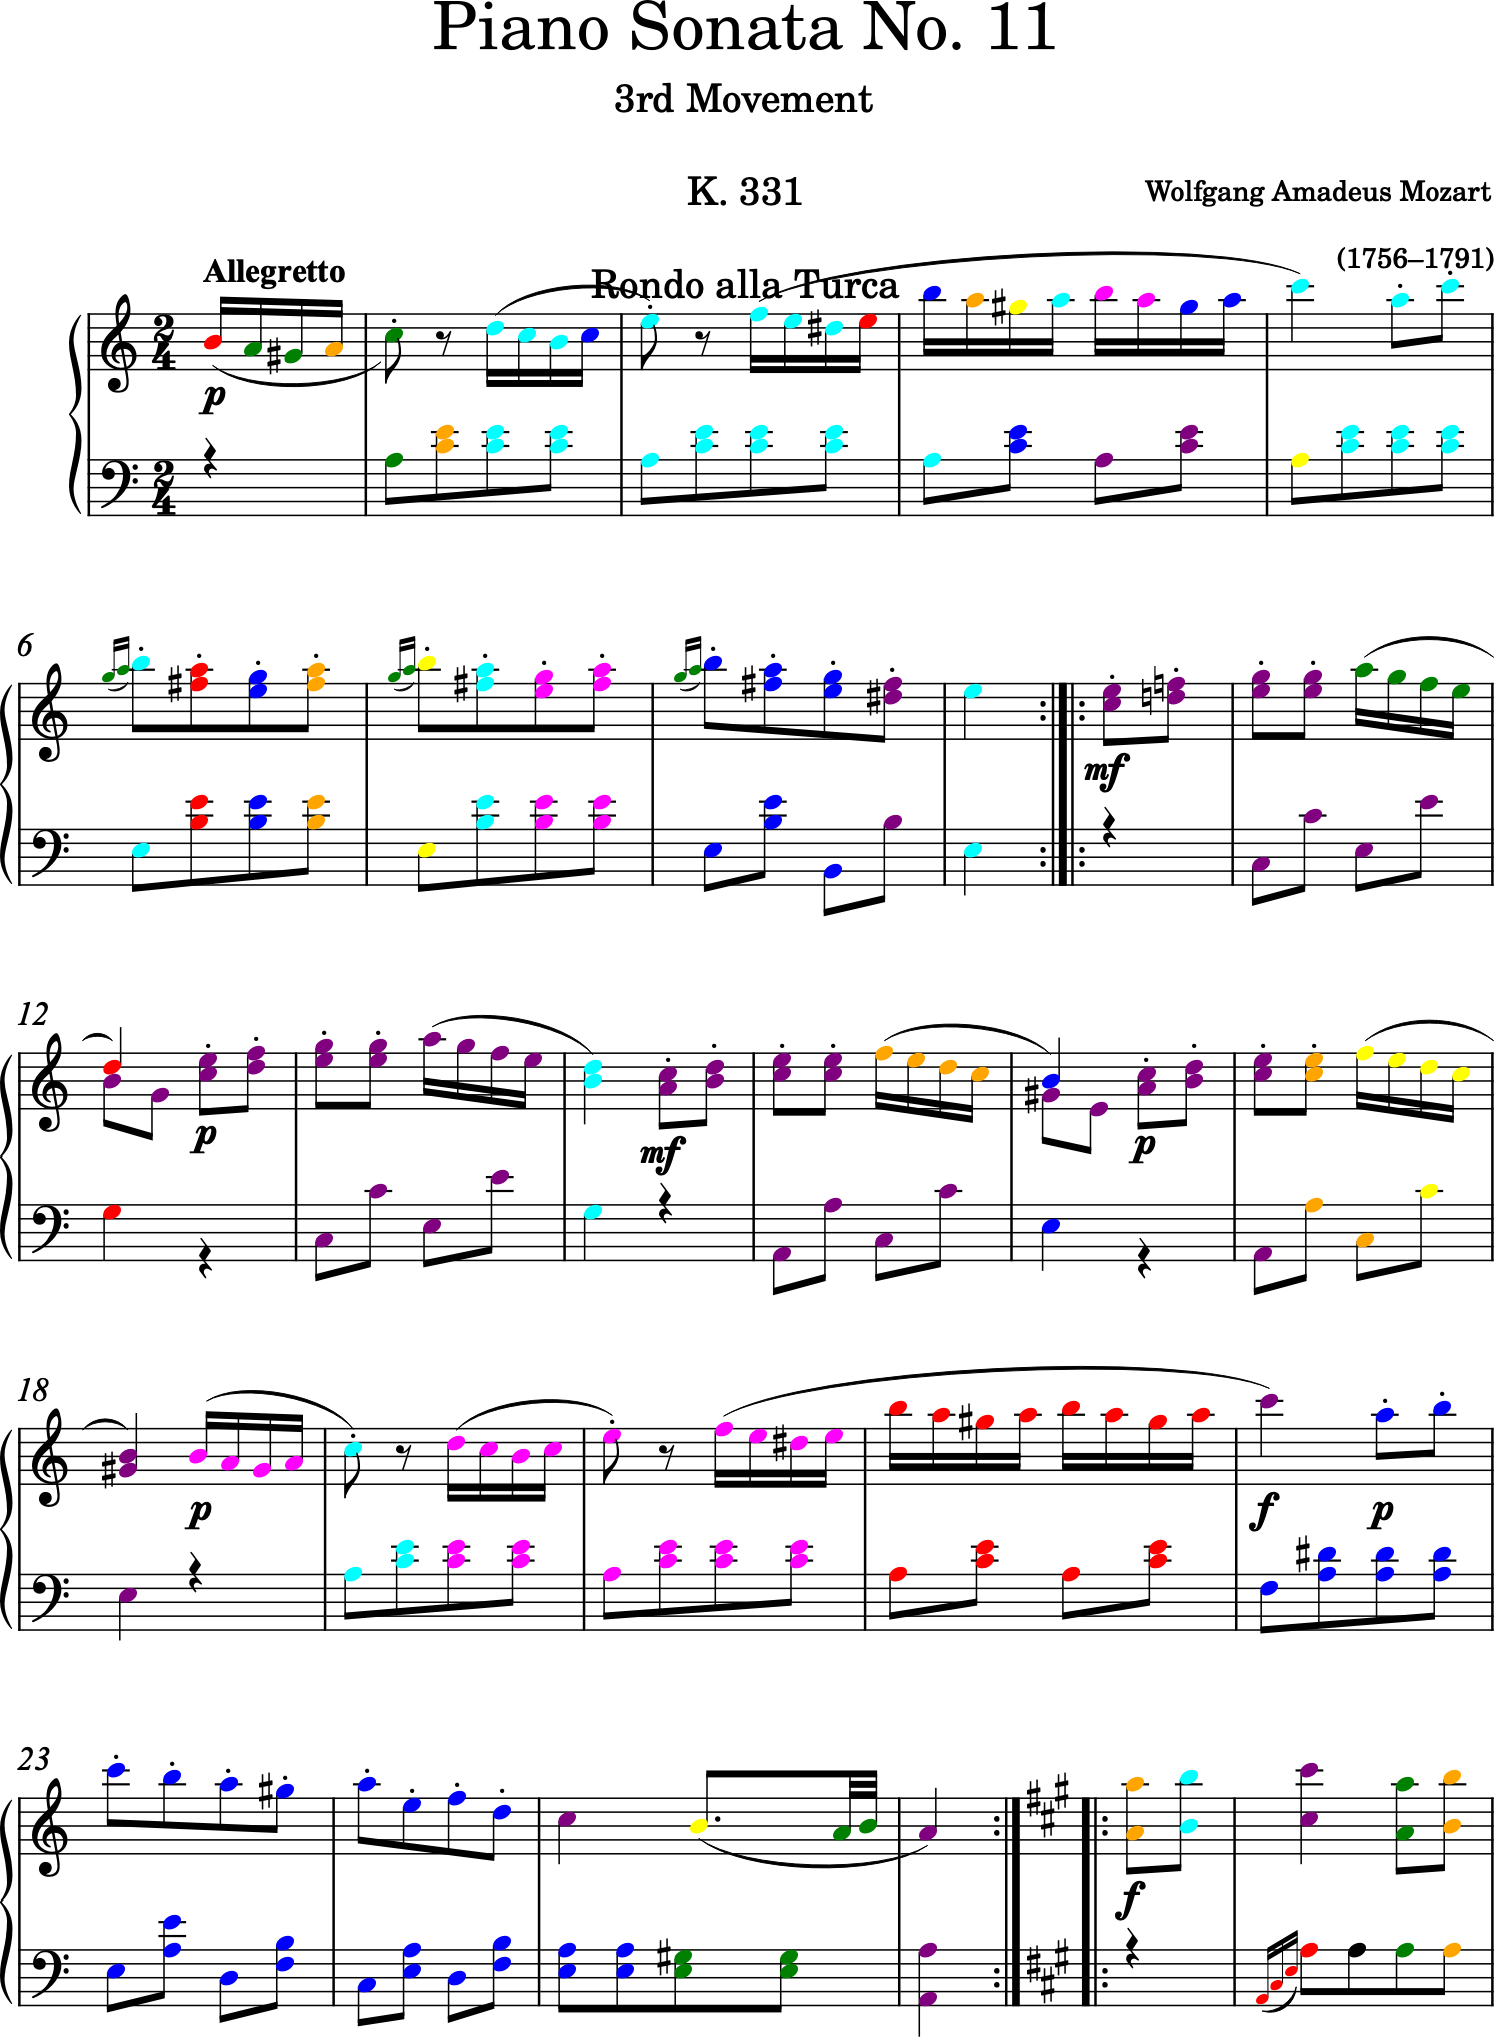

In [49]:
import music21
import os

def extract_score_attributes(part):
    score_data = []
    for element in part.flat.notes:
        if isinstance(element, music21.note.Note):
            attributes = {
                'offset': element.offset,
                'pitch': element.pitch.midi,
                'duration': element.quarterLength,
                'measure': element.measureNumber
            }
            score_data.append(attributes)
        elif isinstance(element, music21.chord.Chord):
            for note in element.notes:
                attributes = {
                    'offset': element.offset,
                    'pitch': note.pitch.midi,
                    'duration': element.quarterLength,
                    'measure': element.measureNumber
                }
                score_data.append(attributes)
    return score_data

def detect_phrases_score(score_data, pitch_threshold=5, duration_threshold=0.5):
    phrases = []
    current_phrase = [score_data[0]['offset']]
    for i in range(1, len(score_data)):
        pitch_change = np.abs(score_data[i]['pitch'] - score_data[i - 1]['pitch'])
        duration_change = np.abs(score_data[i]['duration'] - score_data[i - 1]['duration'])
        if pitch_change > pitch_threshold or duration_change > duration_threshold:
            current_phrase.append(score_data[i - 1]['offset'])
            phrases.append(current_phrase)
            current_phrase = [score_data[i]['offset']]
    current_phrase.append(score_data[-1]['offset'])
    phrases.append(current_phrase)
    return phrases

def highlight_phrases_in_score(score, phrases):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
    color_index = 0
    
    for phrase in phrases:
        start_beat, end_beat = phrase[0], phrase[1]
        for element in score.flat.notes:
            if element.quarterLength != 0:
                beat = int(element.offset / (element.quarterLength / 4))  # assuming each beat is a quarter note
                if start_beat <= beat <= end_beat:
                    element.style.color = colors[color_index]
        color_index = (color_index + 1) % len(colors)
    
    return score

def detect_phrases_from_ssm(ssm, similarity_threshold=0.5):
    num_beats = ssm.shape[0]
    phrases = []
    current_phrase = [0]
    
    for i in range(1, num_beats):
        max_similarity = np.max(ssm[i, :i])
        if max_similarity < similarity_threshold:
            current_phrase.append(i - 1)
            phrases.append(current_phrase)
            current_phrase = [i]
    current_phrase.append(num_beats - 1)
    phrases.append(current_phrase)
    
    return phrases

# Example self-similarity matrix
ssm = np.array([
    [1.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0],
    [0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])

# Detect phrases using the self-similarity matrix
phrases_model_p = detect_phrases_from_ssm(left_self_sim_mat3)
print("Detected phrases:", phrases_model_p)

# Load the score

# Highlight the phrases in the score
highlighted_score = highlight_phrases_in_score(sample_score, phrases_model_p)

# Ensure the directory exists
output_dir = '/mnt/data'
output_file = 'file_highlighted.xml'
#os.makedirs(output_dir, exist_ok=True)

# Save the highlighted score to a new MusicXML file
#highlighted_score.write('musicxml', os.path.join(output_dir, output_file))

# Optionally, show the highlighted score
highlighted_score.show()
